In [1]:
import os
import cv2
import torch
import numpy as np
from tqdm import tqdm

from PIL import Image
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix


import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader,Dataset

import torchvision
from torchvision import datasets, models, transforms

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

device

device(type='cuda')

In [4]:
dinov2_vits14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
dinov2_vits14 = dinov2_vits14.to(device)

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vits14_pretrain.pth
100%|██████████| 84.2M/84.2M [00:00<00:00, 90.5MB/s]


In [ ]:
for name, param in dinov2_vits14.named_parameters():
  print(name)

cls_token
pos_embed
mask_token
patch_embed.proj.weight
patch_embed.proj.bias
blocks.0.norm1.weight
blocks.0.norm1.bias
blocks.0.attn.qkv.weight
blocks.0.attn.qkv.bias
blocks.0.attn.proj.weight
blocks.0.attn.proj.bias
blocks.0.ls1.gamma
blocks.0.norm2.weight
blocks.0.norm2.bias
blocks.0.mlp.fc1.weight
blocks.0.mlp.fc1.bias
blocks.0.mlp.fc2.weight
blocks.0.mlp.fc2.bias
blocks.0.ls2.gamma
blocks.1.norm1.weight
blocks.1.norm1.bias
blocks.1.attn.qkv.weight
blocks.1.attn.qkv.bias
blocks.1.attn.proj.weight
blocks.1.attn.proj.bias
blocks.1.ls1.gamma
blocks.1.norm2.weight
blocks.1.norm2.bias
blocks.1.mlp.fc1.weight
blocks.1.mlp.fc1.bias
blocks.1.mlp.fc2.weight
blocks.1.mlp.fc2.bias
blocks.1.ls2.gamma
blocks.2.norm1.weight
blocks.2.norm1.bias
blocks.2.attn.qkv.weight
blocks.2.attn.qkv.bias
blocks.2.attn.proj.weight
blocks.2.attn.proj.bias
blocks.2.ls1.gamma
blocks.2.norm2.weight
blocks.2.norm2.bias
blocks.2.mlp.fc1.weight
blocks.2.mlp.fc1.bias
blocks.2.mlp.fc2.weight
blocks.2.mlp.fc2.bias
blocks

In [ ]:
for name, param in dinov2_vits14.named_parameters():
  param.requires_grad = False

In [5]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_transforms1 = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

from torchvision import transforms

data_transforms2 = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(), # Convert to tensor
        transforms.ToPILImage(), # Convert back to PIL Image
        transforms.ToTensor(), # Convert back to tensor (now in RGB)
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.ToPILImage(), # Convert back to PIL Image
        transforms.ToTensor(), # Convert back to tensor (now in RGB)
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.ToPILImage(), # Convert back to PIL Image
        transforms.ToTensor(), # Convert back to tensor (now in RGB)
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [6]:
ROOT_PATH = '/content/drive/MyDrive/dataset'


image_datasets = {
    x: datasets.ImageFolder(os.path.join(ROOT_PATH, x), data_transforms1[x])
    for x in ['train', 'val', 'test']
}
print(image_datasets)
class_names = image_datasets['train'].classes
print(class_names)
class_to_idx = {c: i for i, c in enumerate(class_names)}
print(class_to_idx)

batch_size = 8
num_workers = 4

data_loaders = {x: DataLoader(image_datasets[x], shuffle=True, batch_size=batch_size, num_workers=4)
    for x in ['train', 'val','test']
}
print(data_loaders)

{'train': Dataset ImageFolder
    Number of datapoints: 936
    Root location: /content/drive/MyDrive/dataset/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           ), 'val': Dataset ImageFolder
    Number of datapoints: 96
    Root location: /content/drive/MyDrive/dataset/val
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           ), 'test': Dataset ImageFolder
    Number of datapoints: 107
    Root location: /content/drive/MyDrive/dataset/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
             

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training CHF:     320
Training Normal:      314
Training Pneumonia:   302
Validation CHF:   32
Validation Normal:    32
Validation Pneumonia: 32




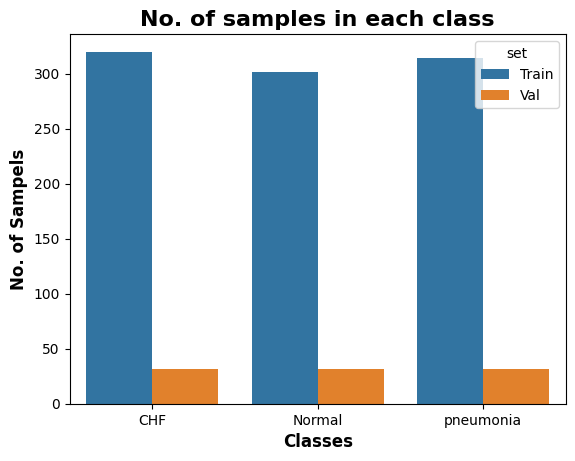

In [7]:
data = torchvision.datasets.ImageFolder('/content/drive/MyDrive/dataset/train')

t_len_chf = data.targets.count(0)
t_len_normal = data.targets.count(1)
t_len_pneumonia = data.targets.count(2)

data = torchvision.datasets.ImageFolder('/content/drive/MyDrive/dataset/val')

v_len_chf = data.targets.count(0)
v_len_normal = data.targets.count(1)
v_len_pneumonia = data.targets.count(2)


no_samples = [t_len_chf, v_len_chf, t_len_normal, v_len_normal, t_len_pneumonia, v_len_pneumonia]
df = {'classes': class_names * 2,
      'set': ['Train', 'Val'] * 3,
      'data': no_samples}

ax = sns.barplot(x='classes', y='data', data=df, hue='set')
ax.set_title(label='No. of samples in each class', weight='bold', fontsize=16)
ax.set_xlabel(xlabel='Classes', weight='bold', fontsize=12)
ax.set_ylabel(ylabel='No. of Sampels', weight='bold', fontsize=12)

print(f'Training CHF:     {t_len_chf}')
print(f'Training Normal:      {t_len_normal}')
print(f'Training Pneumonia:   {t_len_pneumonia}')

print(f'Validation CHF:   {v_len_chf}')
print(f'Validation Normal:    {v_len_normal}')
print(f'Validation Pneumonia: {v_len_pneumonia}\n\n')

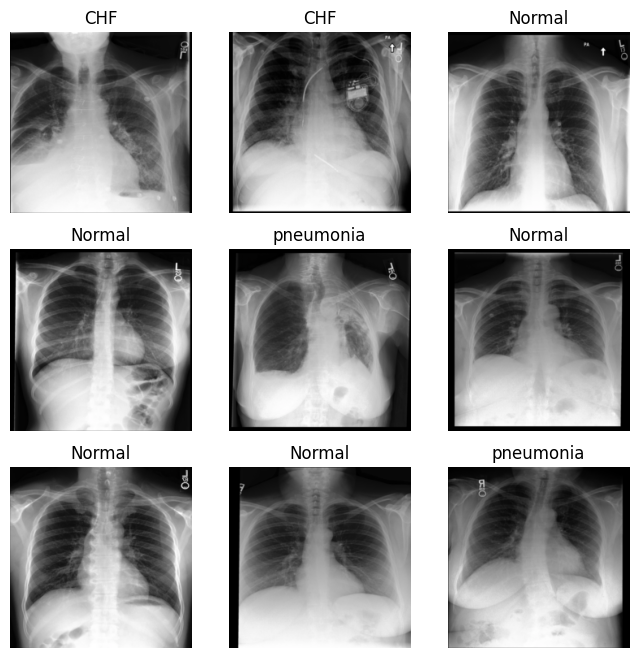

In [8]:
import matplotlib.pyplot as plt
import torch
import torchvision

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
training_data = image_datasets['train']

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(class_names[label])
    plt.axis("off")

    # Permute the dimensions and denormalize the image
    img = img.permute(1, 2, 0)
    # Get the ImageNet mean and standard deviation
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    # Denormalize the image
    img = img * std + mean
    # Clip the values to the range [0, 1]
    img = torch.clamp(img, 0, 1)
    # Convert the image to a NumPy array
    img = img.numpy()

    plt.imshow(img)
plt.show()


In [9]:
class DinoVisionTransformerClassifier(nn.Module):
    def __init__(self):
        super(DinoVisionTransformerClassifier, self).__init__()
        self.transformer = dinov2_vits14
        self.classifier = nn.Sequential(
            nn.Linear(384, 256),
            nn.ReLU(),
            nn.Linear(256, len(class_names))
        )

    def forward(self, x):
        x = self.transformer(x)
        x = self.transformer.norm(x)
        x = self.classifier(x)
        return x

model = DinoVisionTransformerClassifier()
model = model.to(device)

In [ ]:
print(model.classifier.parameters())

<generator object Module.parameters at 0x7d0e304bbd10>


In [ ]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW([
    #{"params": model.transformer.parameters(), "lr": 1e-4},  # Lower learning rate for backbone
    {"params": model.classifier.parameters(), "lr": 1e-4},   # Higher learning rate for classifier
])
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                                                   max_lr=1e-4,
                                                   total_steps=20*len(data_loaders['train']))

TRAIN WITH VALIDATON, identify the best validation loss

In [44]:
num_epoch = 12
best_loss = float('inf')
MODEL_PATH = '/content/drive/MyDrive/models/dinoxray.pth'
for epoch in range(num_epoch):
    train_acc = 0
    train_loss = 0
    train_cnt=0
    loop = tqdm(data_loaders['train'])
    model.train()
    for idx, (features, labels) in enumerate(loop):
        features = features.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)

        predictions = outputs.argmax(dim=1, keepdim=True).squeeze()
        correct = (predictions == labels).sum().item()
        accuracy = correct / batch_size

        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        loop.set_description(f"Epoch [{epoch}/{num_epoch}]")
        loop.set_postfix(loss=loss.item(), acc=accuracy)
        train_loss += loss.item()
        train_acc += accuracy
        train_cnt += 1

    train_loss = train_loss/train_cnt
    train_acc=train_acc/train_cnt
    print(f'Training LOSS:     {train_loss}')
    print(f'Training Acc:      {train_acc}')
    print(f'Training Batch:   {train_cnt}')


    val_acc = 0
    val_loss = 0
    val_cnt=0
    loop = tqdm(data_loaders['val'])
    model.eval()
    for idx, (features, labels) in enumerate(loop):
        features = features.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)

        predictions = outputs.argmax(dim=1, keepdim=True).squeeze()
        correct = (predictions == labels).sum().item()
        accuracy = correct / batch_size

        loop.set_description(f"Epoch [{epoch}/{num_epoch}]")
        loop.set_postfix(loss=loss.item(), acc=accuracy)
        val_loss += loss.item()
        val_acc += accuracy
        val_cnt += 1

    val_loss = val_loss/val_cnt
    val_acc=val_acc/val_cnt
    print(f'Validation LOSS:     {val_loss}')
    print(f'Validation Acc:      {val_acc}')
    print(f'Validation Batch:   {val_cnt}')
    print(f'Best loss:   {best_loss}')

    if val_loss < best_loss:
        best_loss = val_loss
        print("Saving the model...",best_loss)
        torch.save(model.state_dict(),MODEL_PATH)


Epoch [0/12]: 100%|██████████| 117/117 [01:27<00:00,  1.33it/s, acc=0.625, loss=0.644]


Training LOSS:     0.5729976730723666
Training Acc:      0.7574786324786325
Training Batch:   117


Epoch [0/12]: 100%|██████████| 12/12 [00:07<00:00,  1.60it/s, acc=0.625, loss=0.767]


Validation LOSS:     0.6594694405794144
Validation Acc:      0.6979166666666666
Validation Batch:   12
Best loss:   inf
Saving the model... 0.6594694405794144


Epoch [1/12]: 100%|██████████| 117/117 [01:29<00:00,  1.31it/s, acc=1, loss=0.415]


Training LOSS:     0.5965374184724612
Training Acc:      0.7414529914529915
Training Batch:   117


Epoch [1/12]: 100%|██████████| 12/12 [00:09<00:00,  1.22it/s, acc=0.625, loss=0.928]


Validation LOSS:     0.6558303559819857
Validation Acc:      0.6770833333333334
Validation Batch:   12
Best loss:   0.6594694405794144
Saving the model... 0.6558303559819857


Epoch [2/12]: 100%|██████████| 117/117 [01:24<00:00,  1.38it/s, acc=0.875, loss=0.347]


Training LOSS:     0.6086919345916846
Training Acc:      0.7382478632478633
Training Batch:   117


Epoch [2/12]: 100%|██████████| 12/12 [00:09<00:00,  1.22it/s, acc=0.5, loss=0.881]


Validation LOSS:     0.6614256203174591
Validation Acc:      0.7083333333333334
Validation Batch:   12
Best loss:   0.6558303559819857


Epoch [3/12]: 100%|██████████| 117/117 [01:27<00:00,  1.34it/s, acc=0.625, loss=0.674]


Training LOSS:     0.584027922178945
Training Acc:      0.7617521367521367
Training Batch:   117


Epoch [3/12]: 100%|██████████| 12/12 [00:07<00:00,  1.58it/s, acc=0.625, loss=0.525]


Validation LOSS:     0.6660859684149424
Validation Acc:      0.6875
Validation Batch:   12
Best loss:   0.6558303559819857


Epoch [4/12]: 100%|██████████| 117/117 [01:28<00:00,  1.33it/s, acc=0.625, loss=0.775]


Training LOSS:     0.5787502552709008
Training Acc:      0.7606837606837606
Training Batch:   117


Epoch [4/12]: 100%|██████████| 12/12 [00:07<00:00,  1.54it/s, acc=0.625, loss=0.853]


Validation LOSS:     0.673302580912908
Validation Acc:      0.6875
Validation Batch:   12
Best loss:   0.6558303559819857


Epoch [5/12]: 100%|██████████| 117/117 [01:27<00:00,  1.34it/s, acc=0.5, loss=0.803]


Training LOSS:     0.5611904999639235
Training Acc:      0.7681623931623932
Training Batch:   117


Epoch [5/12]: 100%|██████████| 12/12 [00:09<00:00,  1.23it/s, acc=0.875, loss=0.408]


Validation LOSS:     0.6564149285356203
Validation Acc:      0.6979166666666666
Validation Batch:   12
Best loss:   0.6558303559819857


Epoch [6/12]: 100%|██████████| 117/117 [01:23<00:00,  1.39it/s, acc=0.5, loss=0.692]


Training LOSS:     0.5416734025009677
Training Acc:      0.7745726495726496
Training Batch:   117


Epoch [6/12]: 100%|██████████| 12/12 [00:10<00:00,  1.15it/s, acc=0.375, loss=1.09]


Validation LOSS:     0.6765560333927473
Validation Acc:      0.6875
Validation Batch:   12
Best loss:   0.6558303559819857


Epoch [7/12]: 100%|██████████| 117/117 [01:26<00:00,  1.35it/s, acc=0.875, loss=0.233]


Training LOSS:     0.5067758009983943
Training Acc:      0.8012820512820513
Training Batch:   117


Epoch [7/12]: 100%|██████████| 12/12 [00:07<00:00,  1.56it/s, acc=0.75, loss=0.292]


Validation LOSS:     0.6867986756066481
Validation Acc:      0.6875
Validation Batch:   12
Best loss:   0.6558303559819857


Epoch [8/12]: 100%|██████████| 117/117 [01:27<00:00,  1.33it/s, acc=0.75, loss=0.432]


Training LOSS:     0.5076847932595983
Training Acc:      0.7895299145299145
Training Batch:   117


Epoch [8/12]: 100%|██████████| 12/12 [00:09<00:00,  1.33it/s, acc=0.875, loss=0.462]


Validation LOSS:     0.6671825125813484
Validation Acc:      0.6875
Validation Batch:   12
Best loss:   0.6558303559819857


Epoch [9/12]: 100%|██████████| 117/117 [01:24<00:00,  1.38it/s, acc=1, loss=0.269]


Training LOSS:     0.4746452358543363
Training Acc:      0.811965811965812
Training Batch:   117


Epoch [9/12]: 100%|██████████| 12/12 [00:11<00:00,  1.09it/s, acc=0.625, loss=0.801]


Validation LOSS:     0.6606171155969301
Validation Acc:      0.6770833333333334
Validation Batch:   12
Best loss:   0.6558303559819857


Epoch [10/12]: 100%|██████████| 117/117 [01:25<00:00,  1.36it/s, acc=1, loss=0.338]


Training LOSS:     0.46188107540464807
Training Acc:      0.8344017094017094
Training Batch:   117


Epoch [10/12]: 100%|██████████| 12/12 [00:07<00:00,  1.60it/s, acc=0.5, loss=0.934]


Validation LOSS:     0.6592363441983858
Validation Acc:      0.7083333333333334
Validation Batch:   12
Best loss:   0.6558303559819857


Epoch [11/12]: 100%|██████████| 117/117 [01:28<00:00,  1.33it/s, acc=0.75, loss=0.6]


Training LOSS:     0.4571267098952562
Training Acc:      0.844017094017094
Training Batch:   117


Epoch [11/12]: 100%|██████████| 12/12 [00:07<00:00,  1.56it/s, acc=0.625, loss=0.453]

Validation LOSS:     0.6619382699330648
Validation Acc:      0.6979166666666666
Validation Batch:   12
Best loss:   0.6558303559819857


TEST

In [49]:
MODELB_PATH = '/content/drive/MyDrive/models/dinoxraybest.pth'
torch.save(model.state_dict(),MODELB_PATH)



In [40]:
model.load_state_dict(torch.load(MODELB_PATH, weights_only=True))

<All keys matched successfully>

In [45]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
test_predicted = []
test_labels = []

with torch.no_grad():
    for features, labels in data_loaders["test"]:
        features = features.to(device)
        labels = labels.to(device)

        # calculate outputs by running images through the network
        outputs = model(features)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.to(device) == labels).sum().item()

        test_labels += (labels.cpu().numpy().tolist())
        test_predicted += (predicted.cpu().numpy().tolist())

print(f'Accuracy of the network on the {len(data_loaders["test"])*6} test images: {100 * correct // total} %')

Accuracy of the network on the 84 test images: 81 %


In [46]:
print(classification_report(test_labels, test_predicted, target_names=class_names))


              precision    recall  f1-score   support

         CHF       0.77      0.84      0.81        32
      Normal       0.85      0.89      0.87        44
   pneumonia       0.81      0.68      0.74        31

    accuracy                           0.81       107
   macro avg       0.81      0.80      0.80       107
weighted avg       0.81      0.81      0.81       107



In [47]:
cm = confusion_matrix(test_labels, test_predicted)
df_cm = pd.DataFrame(
    cm,
    index = class_names,
    columns = class_names
)
df_cm

,CHF,Normal,pneumonia
CHF,27,3,2
Normal,2,39,3
pneumonia,6,4,21


<ipython-input-48-29ce90041e03>:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


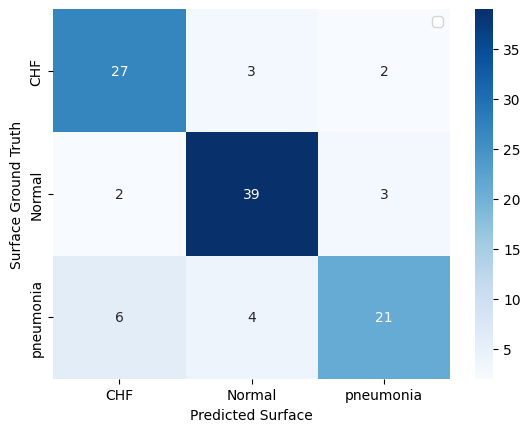

In [48]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    plt.ylabel("Surface Ground Truth")
    plt.xlabel("Predicted Surface")
    plt.legend()

show_confusion_matrix(df_cm)

In [39]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW([
    {"params": model.transformer.parameters(), "lr": 1e-4, "eps" : 1},  # Lower learning rate for backbone
    #{"params": model.classifier.parameters(), "lr": 1e-4, "eps" : 1e-5},   # Higher learning rate for classifier
])
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                                                   max_lr=1e-4,
                                                   total_steps=12*len(data_loaders['train']))

In [43]:
for name, param in model.transformer.named_parameters():
  if "blocks.10" in name:
    param.requires_grad = True
    print(name)
  else:
    param.requires_grad = False


blocks.10.norm1.weight
blocks.10.norm1.bias
blocks.10.attn.qkv.weight
blocks.10.attn.qkv.bias
blocks.10.attn.proj.weight
blocks.10.attn.proj.bias
blocks.10.ls1.gamma
blocks.10.norm2.weight
blocks.10.norm2.bias
blocks.10.mlp.fc1.weight
blocks.10.mlp.fc1.bias
blocks.10.mlp.fc2.weight
blocks.10.mlp.fc2.bias
blocks.10.ls2.gamma


In [42]:
# Freeze classifier weights
for param in model.classifier.parameters():
    param.requires_grad = False


In [ ]:
import os
import sys
import argparse
import cv2
import random
import colorsys
import requests
from io import BytesIO

import skimage.io
from skimage.measure import find_contours
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms as pth_transforms
import numpy as np
from PIL import Image

import utils
import vision_transformer as vits


def apply_mask(image, mask, color, alpha=0.5):
    for c in range(3):
        image[:, :, c] = image[:, :, c] * (1 - alpha * mask) + alpha * mask * color[c] * 255
    return image


def random_colors(N, bright=True):
    """
    Generate random colors.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors


def display_instances(image, mask, fname="test", figsize=(5, 5), blur=False, contour=True, alpha=0.5):
    fig = plt.figure(figsize=figsize, frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax = plt.gca()

    N = 1
    mask = mask[None, :, :]
    # Generate random colors
    colors = random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    margin = 0
    ax.set_ylim(height + margin, -margin)
    ax.set_xlim(-margin, width + margin)
    ax.axis('off')
    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]
        _mask = mask[i]
        if blur:
            _mask = cv2.blur(_mask,(10,10))
        # Mask
        masked_image = apply_mask(masked_image, _mask, color, alpha)
        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        if contour:
            padded_mask = np.zeros((_mask.shape[0] + 2, _mask.shape[1] + 2))
            padded_mask[1:-1, 1:-1] = _mask
            contours = find_contours(padded_mask, 0.5)
            for verts in contours:
                # Subtract the padding and flip (y, x) to (x, y)
                verts = np.fliplr(verts) - 1
                p = Polygon(verts, facecolor="none", edgecolor=color)
                ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8), aspect='auto')
    fig.savefig(fname)
    print(f"{fname} saved.")
    return
